**A5: KAGGLE CHALLENGE**  
Team Name: lost_husky  
By: Kevin Ko  

## Loading Data and Import Statements

In [ ]:
# loading data
from sklearn.model_selection import train_test_split
import numpy as np

# ignore warnings for this assignment
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
from sklearn.metrics import mean_squared_error

import requests

def save_file(url, file_name):
    r = requests.get(url)
    with open(file_name, 'wb') as f:
        f.write(r.content)

# retrieve csv file from course website    
save_file('https://homes.cs.washington.edu/~vinitra/cse416/a5/edx_train.csv', 'edx_train.csv')
save_file('https://homes.cs.washington.edu/~vinitra/cse416/a5/edx_test.csv', 'edx_test.csv')

# load the data
edx_train = pd.read_csv('edx_train.csv')  # csv file with features and lables
edx_test = pd.read_csv('edx_test.csv')    # csv file with only features

# for model consistency and reproducible results
RSEED = 50

# Looking through the Data:  
From a little exploring and inspection, we find that we have the following features ( `edx_train.columns` ) : 'course_id', 'userid_DI', 'registered' 'viewed', 'explored', 'certified', 'final_cc_cname_DI', 'LoE_DI', 'YoB', 'gender', 'start_time_DI', 'last_event_DI', 'nevents', 'ndays_act', 'nplay_video','nchapters', 'nforum_posts. 

Shown below is the methods of how some selected features were 're-organized' in order for models to be able to perform predictions on these features.


In [ ]:
edx_train.head(5)

,course_id,userid_DI,registered,viewed,explored,certified,final_cc_cname_DI,LoE_DI,YoB,gender,start_time_DI,last_event_DI,nevents,ndays_act,nplay_video,nchapters,nforum_posts
0,HarvardX/CS50x/2012,MHxPC130288921,1,0,0,0,Unknown/Other,Bachelor's,1988.0,m,8/30/12,unk,0.0,0.0,0.0,0.0,0
1,HarvardX/PH207x/2012_Fall,MHxPC130043703,1,1,1,1,India,Doctorate,1970.0,m,9/4/12,1/16/13,2550.0,21.0,10.0,14.0,0
2,HarvardX/CS50x/2012,MHxPC130082773,1,1,0,0,United States,Master's,1983.0,m,2/12/13,2/12/13,10.0,1.0,0.0,1.0,0
3,HarvardX/PH207x/2012_Fall,MHxPC130186614,1,1,1,1,Other Africa,Bachelor's,1984.0,m,10/16/12,1/15/13,6015.0,50.0,616.0,15.0,0
4,HarvardX/CS50x/2012,MHxPC130113075,1,1,0,0,United States,Secondary,1997.0,m,4/11/13,4/12/13,6.0,2.0,0.0,1.0,0


For model training, userID is intentionally left out as this would not provide meaningful results when making predictions. "final_cc_cname_DI" was also intentionally left out, as decided because although IP addresses might provide informative data, they are highly susceptible to change as some students might use a VPN instead, creating uneccessary accounts of error in this case. 

For course_id, we would not take that into account for our models as all courses through looking at the given data, is taken in Harvard.

For genders, females will be represented as the value 0, males as 1, other as 2, unk as -1  

For level of education:  
* Less than Secondary: 0
* Secondary          : 1
* Bachelor's         : 2
* Master's           : 3
* Doctorate          : 4
* unk                : -1

For now, the registration dates will be left out of the model predictions.


In [ ]:
# feature organizing and renaming run one time ONLY 
# gender
gender_dummy = {'f': 0, 'm': 1, 'o':2, 'unk': -1}
edx_train.gender = [gender_dummy[x] for x in edx_train.gender]
edx_test.gender = [gender_dummy[x] for x in edx_test.gender]

# level of education
education_level = {'Less than Secondary': 0, 'Secondary': 1, 'Bachelor\'s': 2, 'Master\'s': 3, 'Doctorate': 4, 'unk': -1}
edx_train.LoE_DI = [education_level[x] for x in edx_train.LoE_DI]
edx_test.LoE_DI = [education_level[x] for x in edx_test.LoE_DI]

In [ ]:
# splitting data into training, validation, and test sets
# 80% training data, 20% validation data
train_data, validation_data = train_test_split(edx_train, test_size = 0.8)

len(train_data)

1751

# **LOGISTIC REGRESSION WITH REGULARIZATION PENALTY**

In [ ]:
# pre-process data before training
target = 'certified'

features = list(edx_train.columns)
features.remove('certified')
features.remove('userid_DI')
features.remove('last_event_DI')
features.remove('final_cc_cname_DI')
features.remove('start_time_DI')
features.remove('course_id')

# change degree type classification to numbers

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

# Logistic Regression with regularization penalty
logistic_reg_model = LogisticRegression(penalty='l2', C=1/3, fit_intercept=False,random_state=RSEED, max_iter=3000)
logistic_reg_model.fit(train_data[features], train_data[target])

predictions = logistic_reg_model.predict(edx_train[features])
prediction_valid = logistic_reg_model.predict(validation_data[features])
#checking accuracy with training data
train_y = np.array(edx_train[target])
valid_y = np.array(validation_data[target])

print("Accuracy with training data:", accuracy_score(train_y, predictions))
print("Accuracy with validation data:", accuracy_score(valid_y, prediction_valid))
print("RMSE training data:", np.sqrt(mean_squared_error(predictions,edx_train[target])))


Accuracy with training data: 0.9419958894724823
Accuracy with validation data: 0.941629798772656
RMSE training data: 0.2408404254429013


#  **RANDOM FOREST CLASSIFIER AND FINDING THE BEST FIT HYPER PARAMETERS**

In the code below, we use GridSearchCV to find the best fitting data to predict our data. We try on the given training data first, and then compare the accuracies with our validation data. Then we will use a graph to see how it performs, while also keeping in mind of overfitting.


In [ ]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Finding best fit for data
hyper_params = {'min_samples_leaf':[1,10,50,100,1000,10000], 'max_depth':[1,5,10,15,20]}
search = GridSearchCV(RandomForestClassifier(), hyper_params, cv=6, return_train_score=True)
search.fit(edx_train[features], edx_train[target])
print(search.best_params_)

{'max_depth': 15, 'min_samples_leaf': 1}


In [ ]:
rfc_train_predict = search.predict(edx_train[features])
rfc_valid_predict = search.predict(validation_data[features])

# Check accuracy
print("[RFC] Accuracy with training data:", accuracy_score(train_y, rfc_train_predict))
print("[RFC] Accuracy with validation data:", accuracy_score(valid_y, rfc_valid_predict))


print("RMSE training data:", np.sqrt(mean_squared_error(rfc_train_predict,edx_train[target])))

[RFC] Accuracy with training data: 0.9964603790819822
[RFC] Accuracy with validation data: 0.9964321392892821
RMSE training data: 0.05949471336192664


In [ ]:
# check random forest classfier feature importance
feature_rfc = pd.DataFrame({'feature': features, 
                           'importance': search.best_estimator_.feature_importances_}).\
                           sort_values('importance', ascending = False)
feature_rfc

,feature,importance
9,nchapters,0.306045
7,ndays_act,0.206395
6,nevents,0.204872
2,explored,0.194074
1,viewed,0.031180
8,nplay_video,0.026694
4,YoB,0.017621
3,LoE_DI,0.006929
5,gender,0.003822
10,nforum_posts,0.002368


# **DECISION TREES**

After using Random Forest Classifiers, we take a look into decision trees and see how they perform on the given training dataset:

In [ ]:
from sklearn.tree import DecisionTreeClassifier

decision_tree_model = DecisionTreeClassifier(max_depth= 20, random_state=RSEED)
decision_tree_model.fit(edx_train[features], edx_train[target])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=20, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=50, splitter='best')

Randomly guessing a maximum depth, we check our accuracy using accuracy_score and find that it fits 99% of the data; however we are not sure if the model is overfitting or not.

In [ ]:
dtm_preds = decision_tree_model.predict(edx_train[features])
dtm_valid_pred = decision_tree_model.predict(validation_data[features])

dtm_accur_train = accuracy_score(train_y, dtm_preds)
dtm_accur_valid = accuracy_score(valid_y, dtm_valid_pred)

print("Accuracy for Decision Tree Model:", dtm_accur_train)
print("Accuracy for Decision Tree Model - validation data:", dtm_accur_valid)

Accuracy for Decision Tree Model: 0.9997716373601279
Accuracy for Decision Tree Model - validation data: 0.9998572855715713


Thus, we use GridSearchCV again to find the best depth and minimum samples leaf for us to make predictions as this would assist us in overfitting the data.

In [ ]:
# Finding the best fit for Decision Tree Classifier

dtm_parameters = {'min_samples_leaf': [1,10,50,100,200,300], 'max_depth': [1,5,10,15,20]}

dtm_best_fit = GridSearchCV(DecisionTreeClassifier(), dtm_parameters, cv=6, return_train_score=True)
dtm_best_fit.fit(edx_train[features], edx_train[target])

print(dtm_best_fit.best_params_)

{'max_depth': 15, 'min_samples_leaf': 10}


Although accuracy has fell compared to our random guess of maximum depths, we can see that the random guessing above actually overfitted our examples. Using Grid Search CV again, we attempt to find the best hyperparameters for our models.

In [ ]:
# Using best model to make predictions
dtm_better_preds = dtm_best_fit.predict(edx_train[features])
dtm_validation_better = dtm_best_fit.predict(validation_data[features])

dtm_accur_better_train = accuracy_score(train_y, dtm_better_preds)
dtm_valid_better_train = accuracy_score(valid_y, dtm_validation_better)


print("Training Accuracy for better fitted Decision Tree Model:", dtm_accur_better_train)
print("Validation Accuracy for better fitted Decistion Tree Model:", dtm_valid_better_train)

Training Accuracy for better fitted Decision Tree Model: 0.9761361041333638
Validation Accuracy for better fitted Decistion Tree Model: 0.9754531183102612


Training and validation accuracy seemingly fell, however we know that we are not overfitting as shown in the two graphs below.

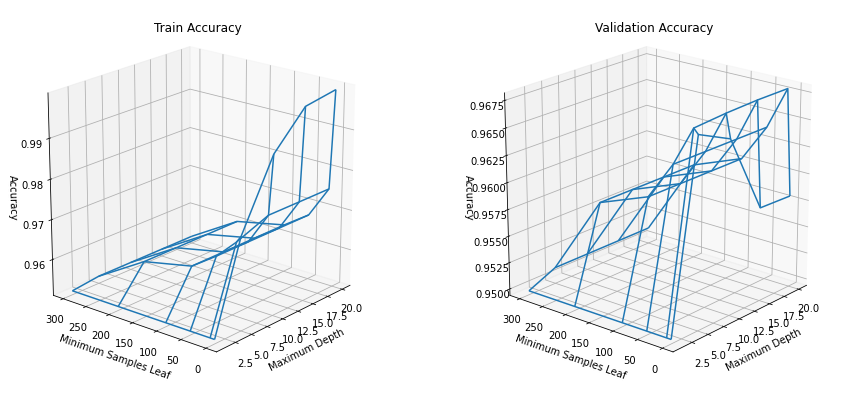

In [ ]:
# Plotting to check for better model/overfitting
import matplotlib.pyplot as plt # for graphing

def plot_scores(ax, title, search, hyperparameters, score_key):
    cv_results = search.cv_results_
    scores = cv_results[score_key]
    scores = scores.reshape((len(hyperparameters['max_depth']), len(hyperparameters['min_samples_leaf'])))
    max_depths = cv_results['param_max_depth'].reshape(scores.shape).data.astype(int)
    min_samples_leafs = cv_results['param_min_samples_leaf'].reshape(scores.shape).data.astype(int)
    
    ax.plot_wireframe(max_depths, min_samples_leafs, scores)
    ax.view_init(20, 220)
    ax.set_xlabel('Maximum Depth')
    ax.set_ylabel('Minimum Samples Leaf')
    ax.set_zlabel('Accuracy')
    ax.set_title(title)


fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

plot_scores(ax1, 'Train Accuracy', dtm_best_fit, dtm_parameters, 'mean_train_score')
plot_scores(ax2, 'Validation Accuracy', dtm_best_fit, dtm_parameters, 'mean_test_score')

# Model Analysis

From what we see on the models/classifiers above, we reach to a conclusion that the Random Forest Classifier performed the best. Shown below is an ROC curve based upon the validation data split for this dataset.

In [ ]:
model_predictions = search.predict(edx_test[features])
to_save = edx_test[['userid_DI']].copy()
to_save.loc[:, 'certified'] = model_predictions
to_save.to_csv('submission.csv', index=False)

Looking at the True Positive Rates compared to the False Positive Rates, we can see that our Random Forest Classifier performed the best when predicted on validation data

Image file saved to /content/roc.png


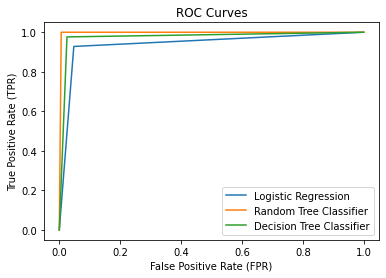

In [ ]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import os

fig, ax = plt.subplots()

# logistic regression
lr_fpr, lr_tpr, _ = roc_curve(validation_data[target], prediction_valid)

# random tree classifier
rfc_fpr, rfc_tpr, _ = roc_curve(validation_data[target], rfc_valid_predict)

# Decision Tree classifier
dtm_fpr, dtm_tpr, _ = roc_curve(validation_data[target], dtm_validation_better)

# plotting
ax.plot(lr_fpr, lr_tpr, label = 'Logistic Regression')
ax.plot(rfc_fpr, rfc_tpr, label = 'Random Tree Classifier')
ax.plot(dtm_fpr, dtm_tpr, label = 'Decision Tree Classifier')
ax.legend(["Logistic Regression","Random Tree Classifier","Decision Tree Classifier"])
ax.set_title('ROC Curves');
ax.set_xlabel('False Positive Rate (FPR)')
ax.set_ylabel('True Positive Rate (TPR)')

filename="roc.png"
fig.savefig(filename)
print("Image file saved to "+os.getcwd()+"/"+filename)